In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator, CubicSpline

In [2]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass, kg

In [3]:
rhoDM = 0.3e9    # dark matter mass density, eV/cm^3

vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

In [4]:
def get_total_events(sphere_type, mx_gev, alpha_t, m_phi, q_thr, exposure):
    outdir = f'/home/yt388/palmer_scratch/data/mphi_{m_phi:.0e}'
    events = np.empty((mx_gev.size, alpha_t.size))

    for i, mx in enumerate(mx_gev):
        for j, alpha in enumerate(alpha_t):
            drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{mx:.5e}_{alpha:.5e}_{m_phi:.0e}.npz', allow_pickle='True')

            # GeV; Counts/hour/GeV
            qq, drdq = drdq_file['q'], drdq_file['drdq']
            events[i][j] = get_nevents(qq, drdq, q_thr, exposure, project_z=True)
    
    return events

In [5]:
def get_nevents(q, drdq, q_thr, exposure, project_z=True):
    # <|cos(theta)|> = 0.5 if q is isotropic
    # so total `q` would look half as small in the z direction
    if project_z:
        q = q * 0.5
        
    drdq[q < q_thr] = 0
    total_rate = np.trapz(drdq, q)
    
    # Exposure in hours
    return total_rate * exposure

In [6]:
def interp_log(alpha_n, events):
    if alpha_n.size == 0:
        return np.asarray([]), np.asarray([])
    
    alpha_log  = np.log10(alpha_n)
    events_log = np.log10(events)
    
    alpha_interp  = np.linspace(alpha_log[0], alpha_log[-1], 50000)
    events_interp = np.interp(alpha_interp, alpha_log, events_log)
    
    return np.power(10, alpha_interp), np.power(10, events_interp)

In [7]:
def cubic_log(x, y):
    x_log = np.log10(x)
    y_log = np.log10(y)
    
    cs = CubicSpline(x_log, y_log)
    
    x_log_interp = np.linspace(x_log[0], x_log[-1], 1000)
    y_log_interp = cs(x_log_interp)
    
    return np.power(10, x_log_interp), np.power(10, y_log_interp)

In [8]:
def get_limit(mx, alpha_n, events):
    cl = 3.0  # 95% CL without background
    
    alpha_lim = np.empty_like(mx)
    
    # Solve for coupling for each DM mass where `events` = cl
    for i, m in enumerate(mx):
        events_mx = events[i]
        
        if np.max(events_mx) < 1e-2:
            alpha_lim[i] = np.nan

        else:
            # Solve by interpolation in log scale
            events_log = np.log10(events_mx)
            alpha_log  = np.log10(alpha_n)
            
            alpha_lim_log  = np.interp(np.log10(cl), events_log, alpha_log)
            alpha_lim[i] = np.power(10, alpha_lim_log)
            
            if (alpha_lim[i] > 1e-4 or alpha_lim[i] == 1e-4):
                alpha_lim[i] = np.nan
            
#             alpha_interp, events_interp = interp_log(alpha_n, events_mx)
#             min_alpha_idx = np.argmin( np.abs( np.log10(events_interp) - np.log10((cl)) ))
            
#             if events_interp[min_alpha_idx] > 1000:
#                 alpha_lim[i] = np.nan
#             else:
#                 alpha_lim[i] = alpha_interp[min_alpha_idx] 
                
    return interp_log(mx[~np.isnan(alpha_lim)], alpha_lim[~np.isnan(alpha_lim)])

## 150 nm nanospheres

In [9]:
sphere_type= 'nanosphere'
R_um = 0.075      # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1
mx_gev  = np.logspace(-4, 10, 40)
alpha_t = np.logspace(-12, -4, 40)

### 10 keV threshold, 1 sphere-month
This is a reasonable value for SQL

In [10]:
q_thr = 10e3 / 1e9   # Momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

# Total events for different mediator masses
# Has projected onto the z-axis
events_0_10kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0,    q_thr, exposure)
events_0_0001_10kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_10kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_10kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_10kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_10kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1,    q_thr, exposure)
events_10_10kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10,   q_thr, exposure)
events_100_10kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100,  q_thr, exposure)
events_1000_10kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_7221/1842996525.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_10kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/1842996525.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_10kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/1842996525.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_10kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/1842996525.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_10kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/1842996525.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_10kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/1842996525.py:9: RuntimeWarning: divide by zero encountered 

Text(0.5, 1.0, '$m_\\phi =$0 eV')

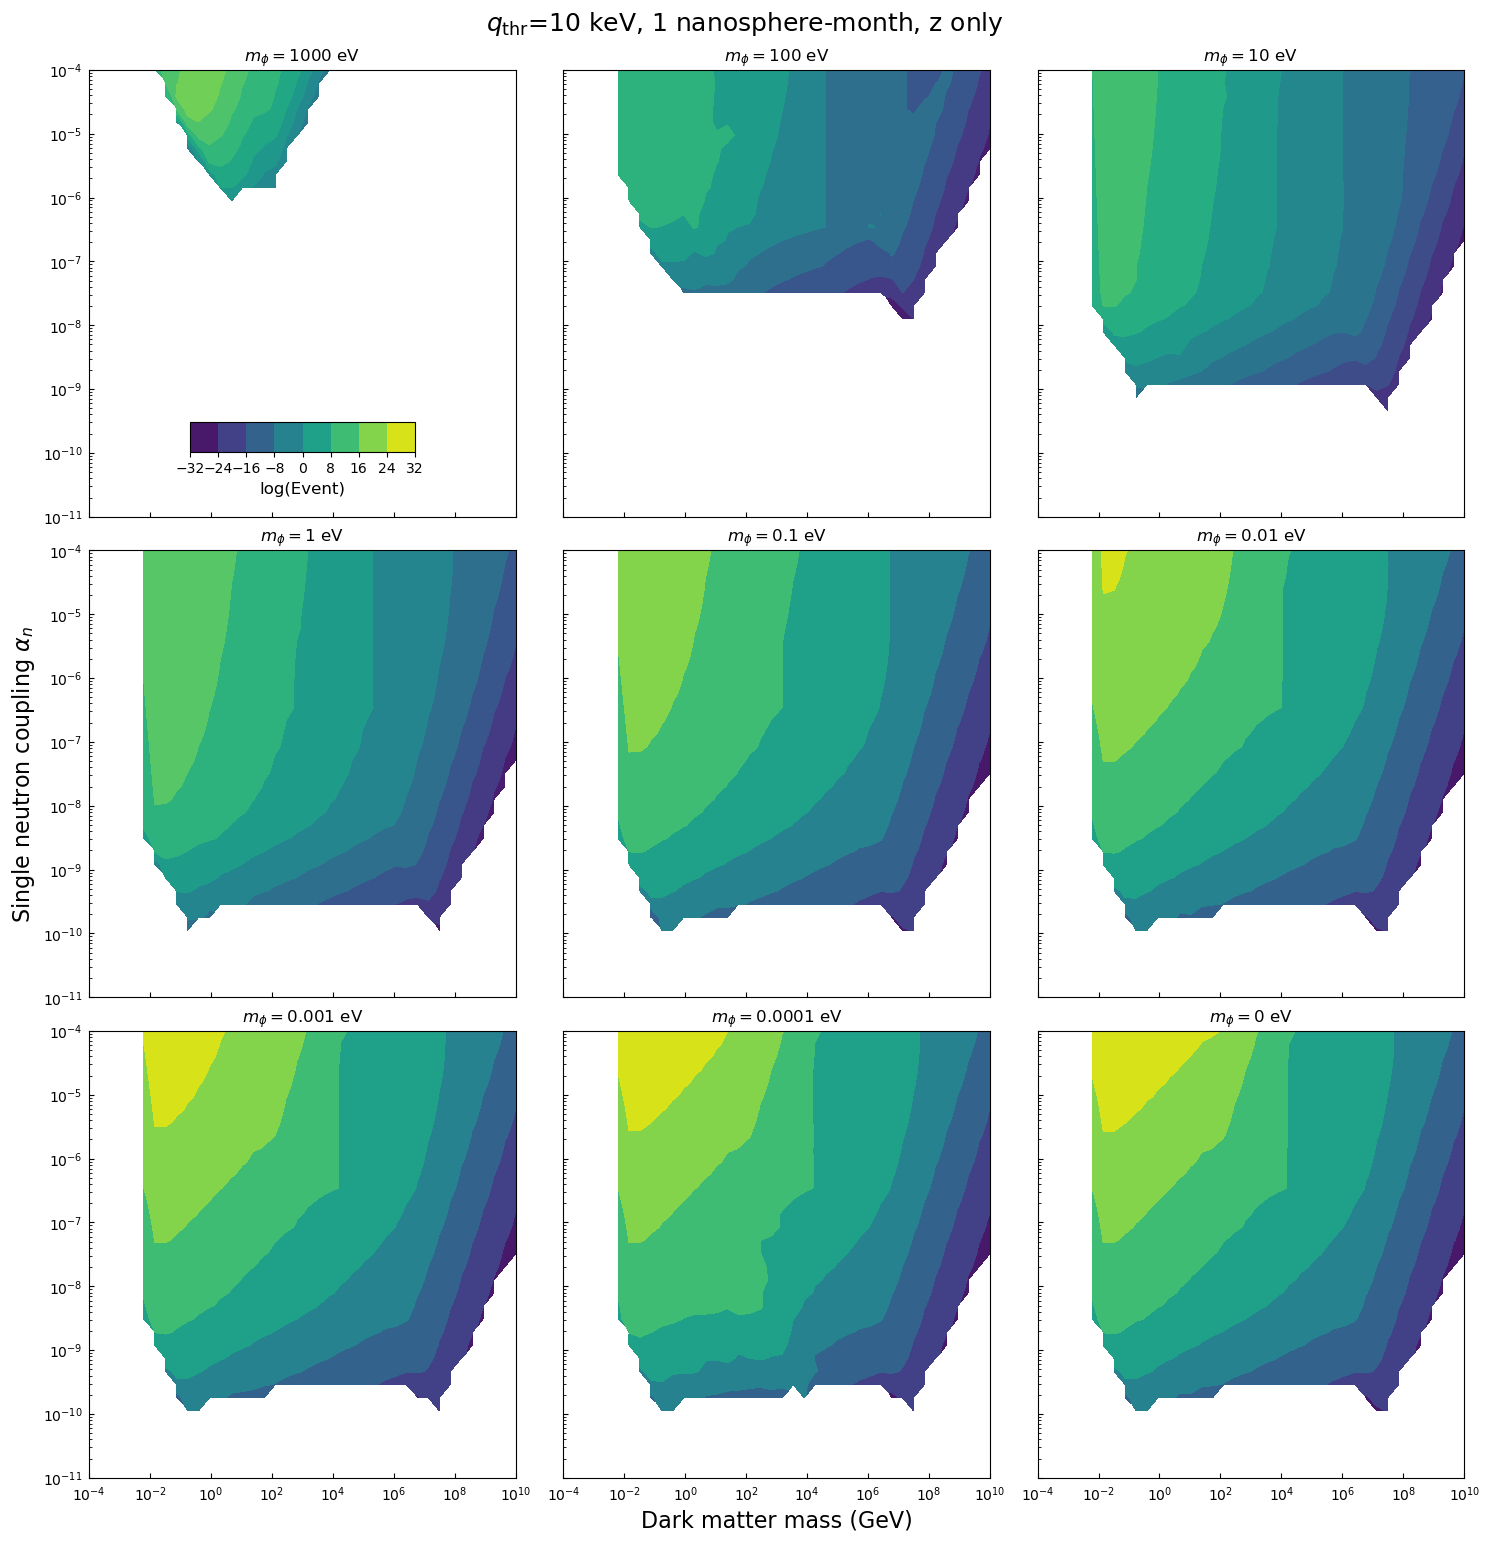

In [11]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_10kev.T),   vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_10kev.T),    vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_10kev.T),     vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_10kev.T),      vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_10kev.T),    vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_10kev.T),   vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_10kev.T),  vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_10kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_10kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()
fig.suptitle(r'$q_{\mathrm{thr}}$=10 keV, 1 nanosphere-mbbonth, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

/tmp/ipykernel_7221/4076309670.py:15: RuntimeWarning: divide by zero encountered in log10
  events_log = np.log10(events_mx)


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

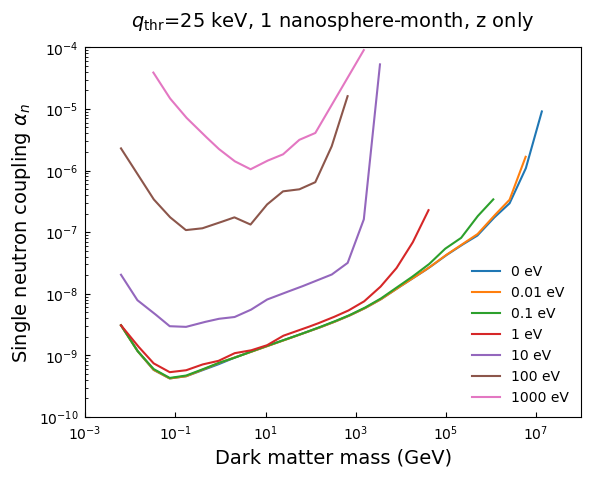

In [18]:
mx_gev_interp, alpha_lim_10kev = [], []
for events in [events_0_10kev, events_0_01_10kev,
               events_0_1_10kev, events_1_10kev, events_10_10kev, events_100_10kev, events_1000_10kev]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    alpha_lim_10kev.append(lim[1])

fig, ax = plt.subplots()

mass_plotted = [0, 0.01, 0.1, 1, 10, 100, 1000]
for i, lim in enumerate(alpha_lim_10kev):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_ylim(1e-10, 1e-4)
ax.set_xlim(1e-3, 1e8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=25 keV, 1 nanosphere-month, z only', fontsize=14, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [19]:
np.savez(f'alpha_n_10kev_1spheremonth.npz',
         mediator_mass_ev = np.asarray([0, 0.01, 0.1, 1, 10, 100, 1000]),
         mx_gev = np.asarray(mx_gev_interp),
         alpha_n_lim = np.asarray(alpha_lim_10kev)
        )

### 10 keV threshold, 100x100 sphere-year

In [15]:
q_thr = 10e3 / 1e9   # Momentum threshold, in GeV
exposure = 1e5 * 12 * 24 * 30   # 100x100 sphere - year

# Total events 1e5for different mediator masses
# Has projecte1e5d onto the z-axis
events_0_10kev_1e5yr      = get_total_events(sphere_type, mx_gev, alpha_t, 0,    q_thr, exposure)
events_0_0001_10kev_1e5yr = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_10kev_1e5yr  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_10kev_1e5yr   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_10kev_1e5yr    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_10kev_1e5yr      = get_total_events(sphere_type, mx_gev, alpha_t, 1,    q_thr, exposure)
events_10_10kev_1e5yr     = get_total_events(sphere_type, mx_gev, alpha_t, 10,   q_thr, exposure)
events_100_10kev_1e5yr    = get_total_events(sphere_type, mx_gev, alpha_t, 100,  q_thr, exposure)
events_1000_10kev_1e5yr   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_7221/2322353153.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_10kev_1e5yr.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/2322353153.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_10kev_1e5yr.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/2322353153.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_10kev_1e5yr.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/2322353153.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_10kev_1e5yr.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/2322353153.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_10kev_1e5yr.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_7221/2322353153.py:9: RuntimeWarnin

Text(0.5, 1.0, '$m_\\phi =$0 eV')

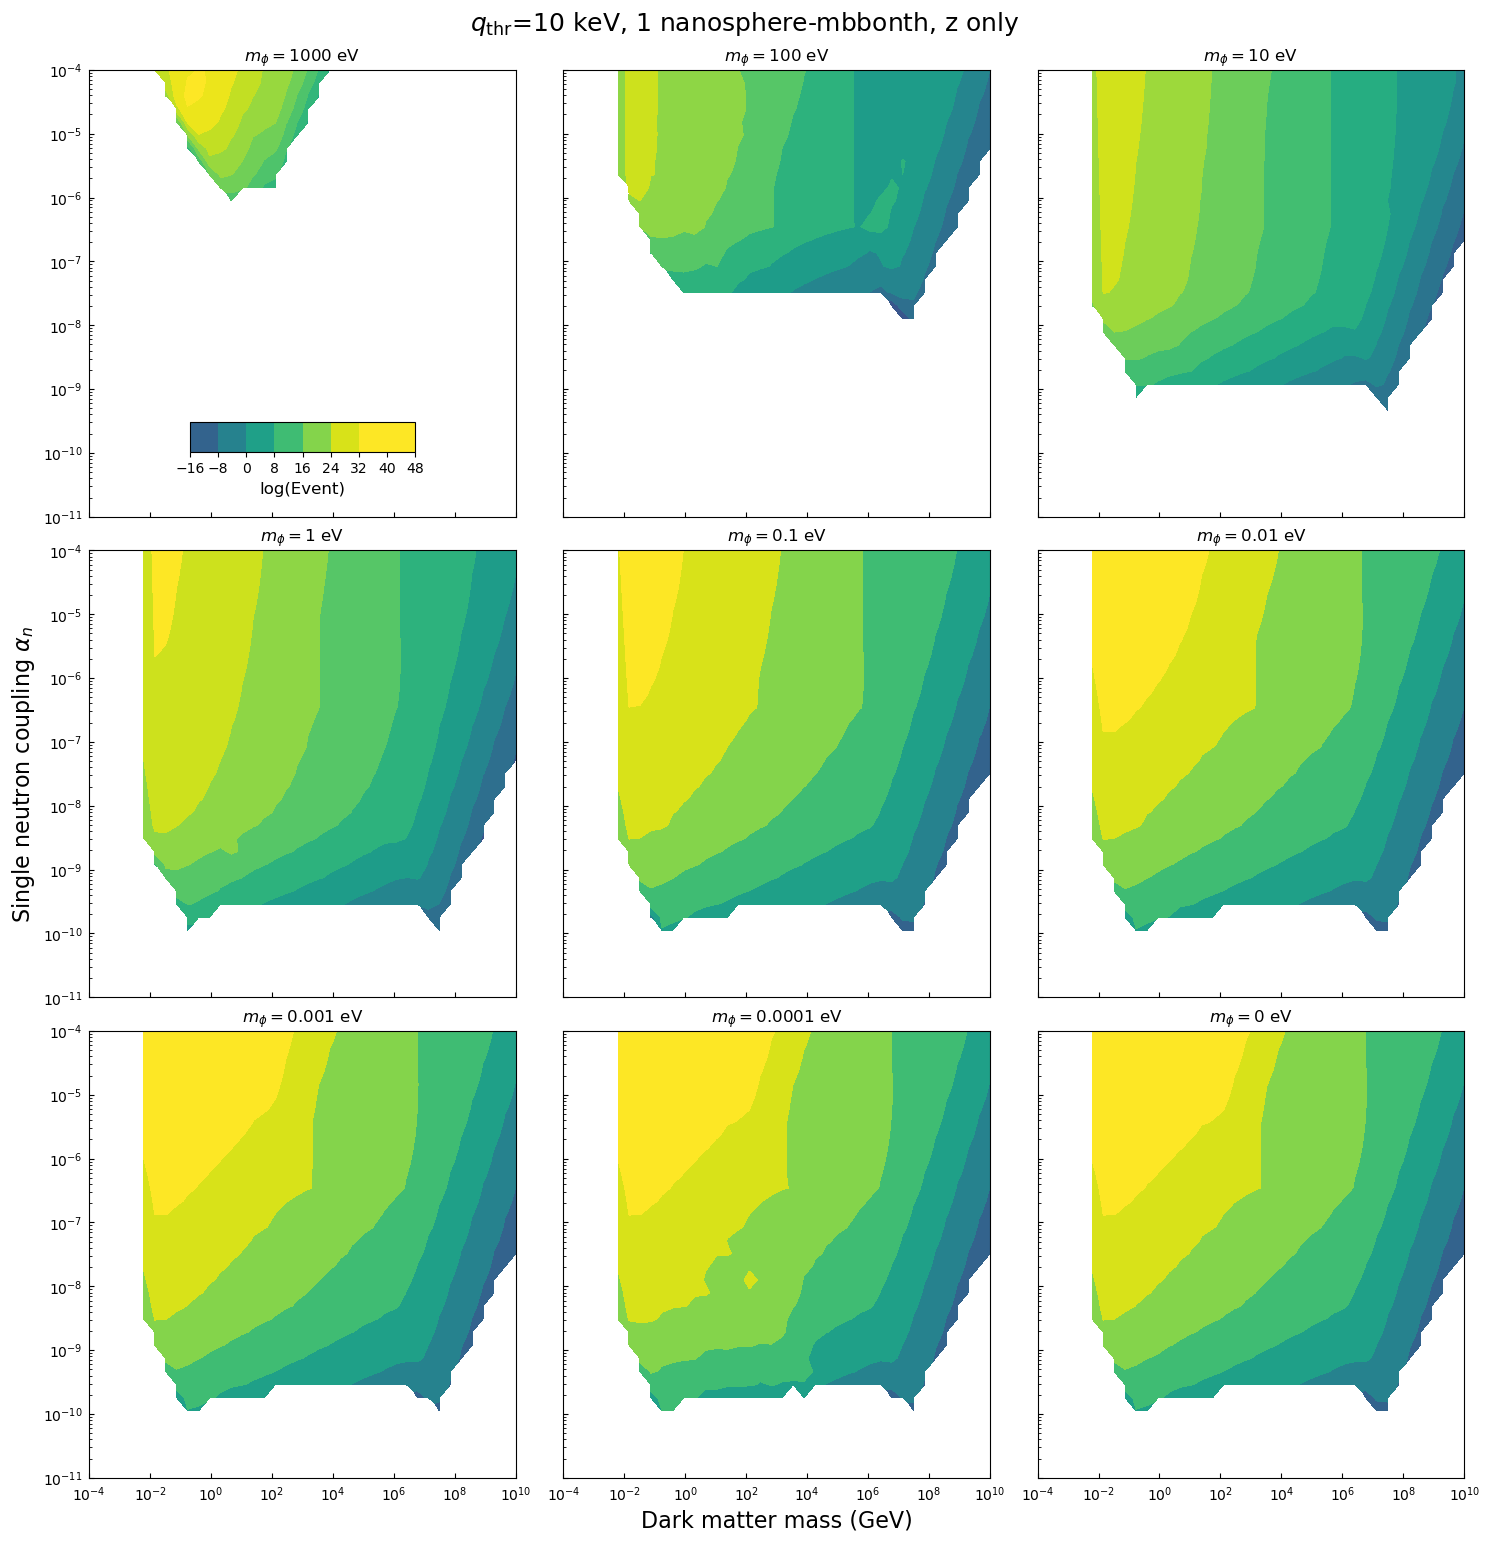

In [16]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_10kev_1e5yr.T),   vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_10kev_1e5yr.T),    vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_10kev_1e5yr.T),     vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_10kev_1e5yr.T),      vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_10kev_1e5yr.T),    vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_10kev_1e5yr.T),   vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_10kev_1e5yr.T),  vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_10kev_1e5yr.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_10kev_1e5yr.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()
fig.suptitle(r'$q_{\mathrm{thr}}$=10 keV, 1 nanosphere-mbbonth, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

/tmp/ipykernel_7221/4076309670.py:15: RuntimeWarning: divide by zero encountered in log10
  events_log = np.log10(events_mx)


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

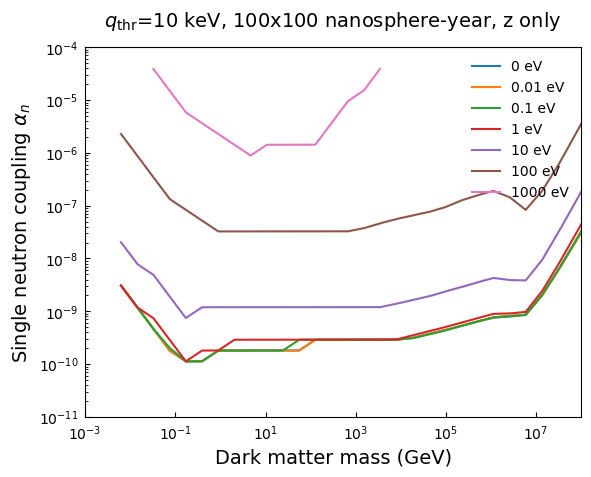

In [22]:
mx_gev_interp, alpha_lim_10kev_1e5yr = [], []
for events in [events_0_10kev_1e5yr, events_0_01_10kev_1e5yr,
               events_0_1_10kev_1e5yr, events_1_10kev_1e5yr, events_10_10kev_1e5yr, events_100_10kev_1e5yr, events_1000_10kev_1e5yr]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    alpha_lim_10kev_1e5yr.append(lim[1])

fig, ax = plt.subplots()

mass_plotted = [0, 0.01, 0.1, 1, 10, 100, 1000]
for i, lim in enumerate(alpha_lim_10kev_1e5yr):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_ylim(1e-11, 1e-4)
ax.set_xlim(1e-3, 1e8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=10 keV, 100x100 nanosphere-year, z only', fontsize=14, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [23]:
np.savez(f'alpha_n_10kev_1e5sphereyear.npz',
         mediator_mass_ev = np.asarray([0, 0.01, 0.1, 1, 10, 100, 1000]),
         mx_gev = np.asarray(mx_gev_interp),
         alpha_n_lim = np.asarray(alpha_lim_10kev_1e5yr)
        )

### 25 keV threshold, 1 sphere-month

In [10]:
q_thr = 25e3 / 1e9   # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

# Total events for different mediator masses
# Has projected onto the z-axis
events_0_25kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0,    q_thr, exposure)
events_0_0001_25kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_25kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_25kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_25kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_25kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1,    q_thr, exposure)
events_10_25kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10,   q_thr, exposure)
events_100_25kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100,  q_thr, exposure)
events_1000_25kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

Plot result

/tmp/ipykernel_8781/2769535761.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_25kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2769535761.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_25kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2769535761.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_25kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2769535761.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_25kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2769535761.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_25kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2769535761.py:9: RuntimeWarning: divide by zero encountered 

Text(0.5, 1.0, '$m_\\phi =$0 eV')

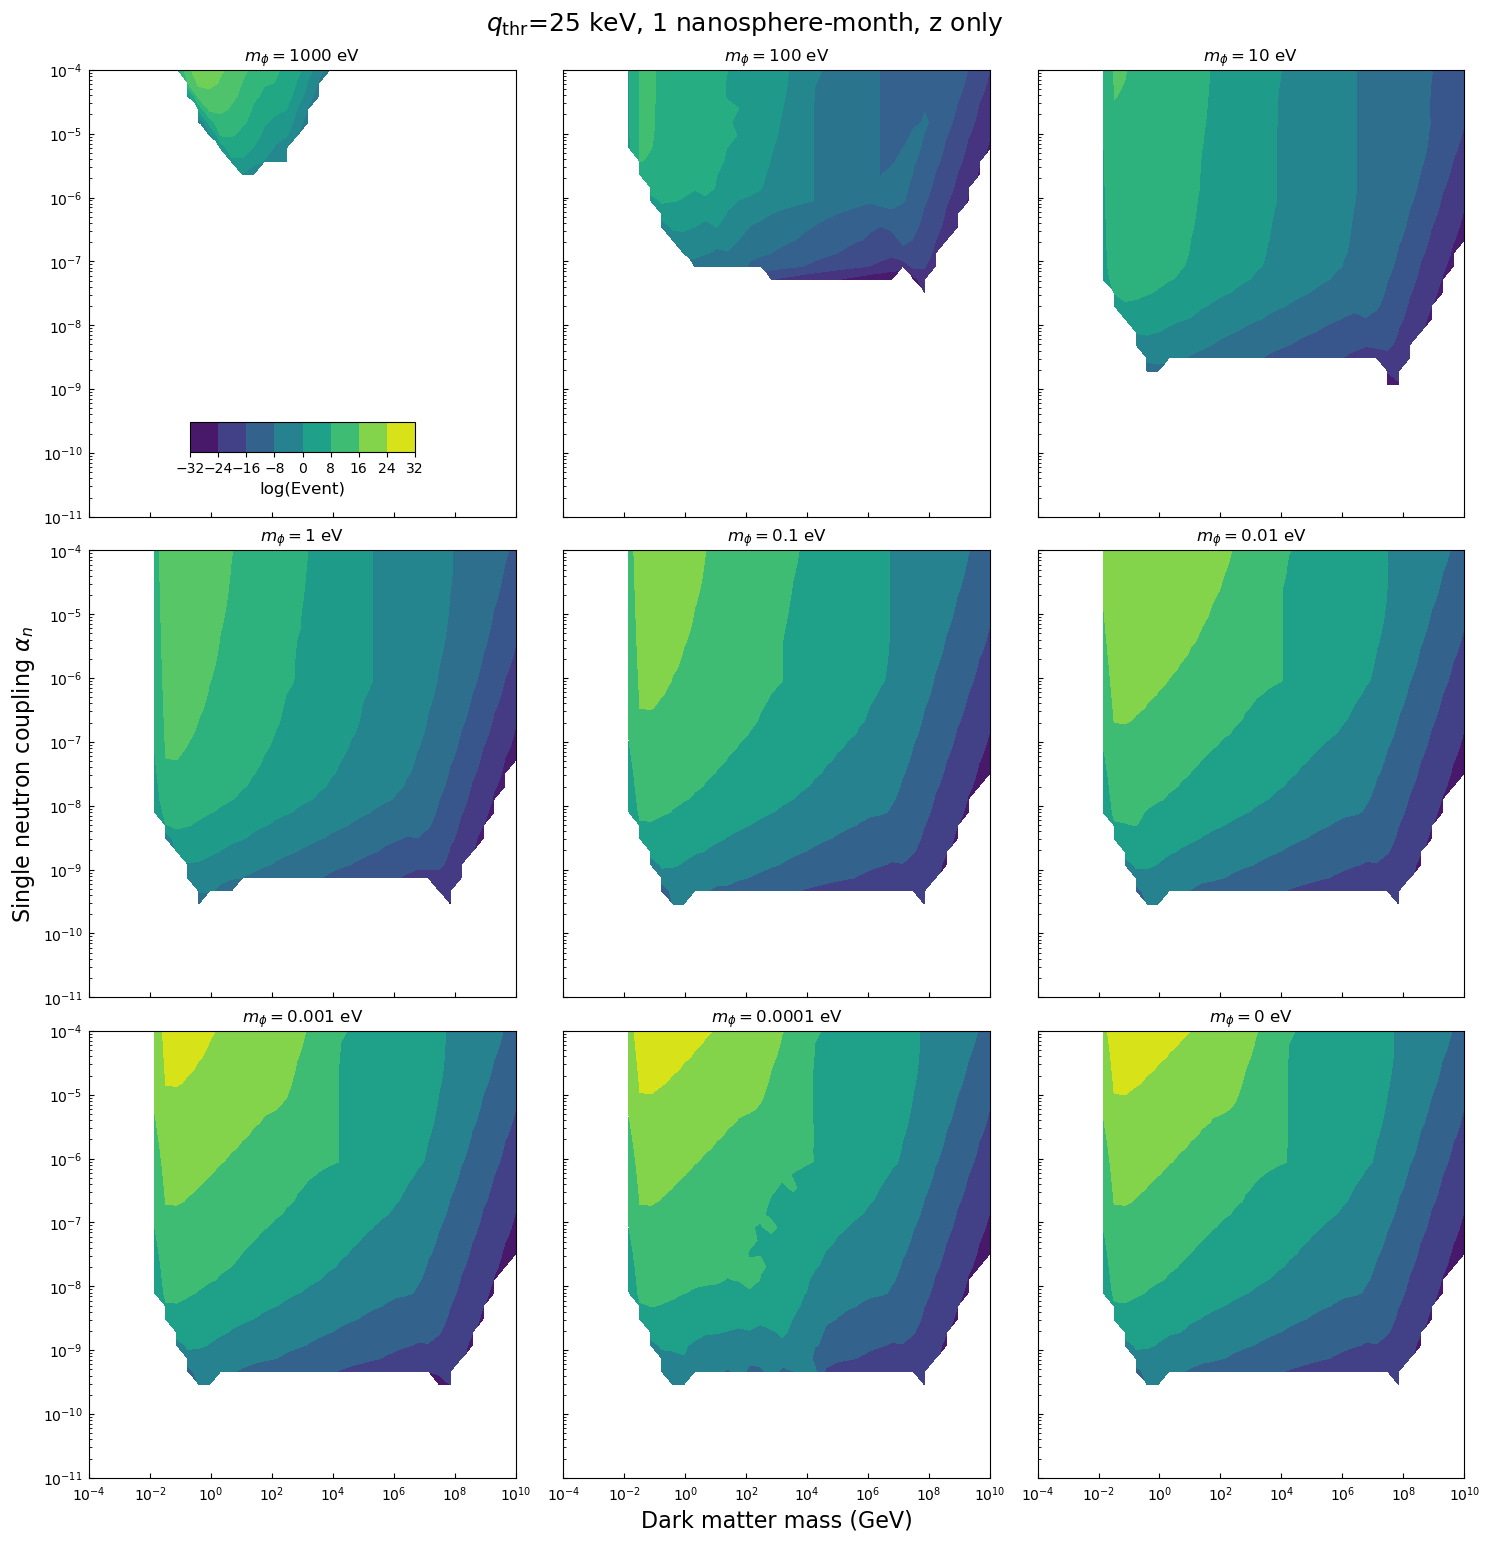

In [11]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_25kev.T),   vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_25kev.T),    vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_25kev.T),     vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_25kev.T),      vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_25kev.T),    vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_25kev.T),   vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_25kev.T),  vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_25kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_25kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()
fig.suptitle(r'$q_{\mathrm{thr}}$=25 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV'b)
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

Now get the 95% CL exclusion limit

In [24]:
mx_gev_interp, alpha_lim = [], []
for events in [events_0_25kev, events_0_01_25kev,
               events_0_1_25kev, events_1_25kev, events_10_25kev, events_100_25kev, events_1000_25kev]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    alpha_lim.append(lim[1])

/tmp/ipykernel_8781/4076309670.py:15: RuntimeWarning: divide by zero encountered in log10
  events_log = np.log10(events_mx)


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

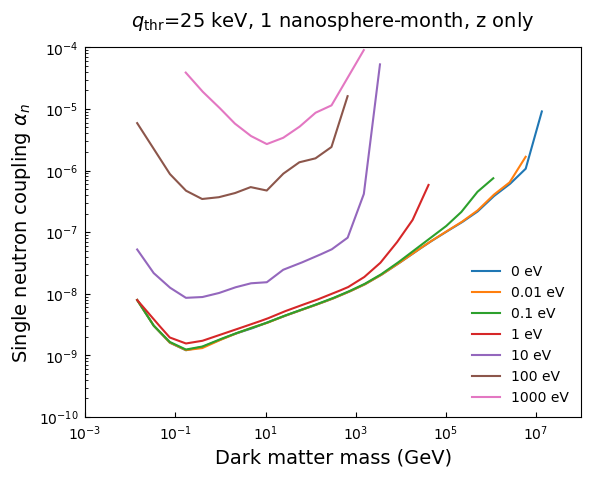

In [27]:
fig, ax = plt.subplots()

mass_plotted = [0, 0.01, 0.1, 1, 10, 100, 1000]
for i, lim in enumerate(alpha_lim):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_ylim(1e-10, 1e-4)
ax.set_xlim(1e-3, 1e8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=25 keV, 1 nanosphere-month, z only', fontsize=14, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

Save the alpha limit into a file

In [28]:
np.savez(f'alpha_n_25kev_1spheremonth.npz',
         mediator_mass_ev = np.asarray([0, 0.01, 0.1, 1, 10, 100, 1000]),
         mx_gev = np.asarray(mx_gev_interp),
         alpha_n_lim = np.asarray(alpha_lim)
        )

### 100 keV threshold, 1 sphere-month

In [29]:
q_thr = 100e3 / 1e9   # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

events_0_100kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0, q_thr, exposure)
events_0_0001_100kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_100kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_100kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_100kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_100kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1, q_thr, exposure)
events_10_100kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10, q_thr, exposure)
events_100_100kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100, q_thr, exposure)
events_1000_100kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_8781/2352636275.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_100kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2352636275.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_100kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2352636275.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_100kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2352636275.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_100kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2352636275.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_100kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/2352636275.py:9: RuntimeWarning: divide by zero encoun

Text(0.5, 1.0, '$m_\\phi =$0 eV')

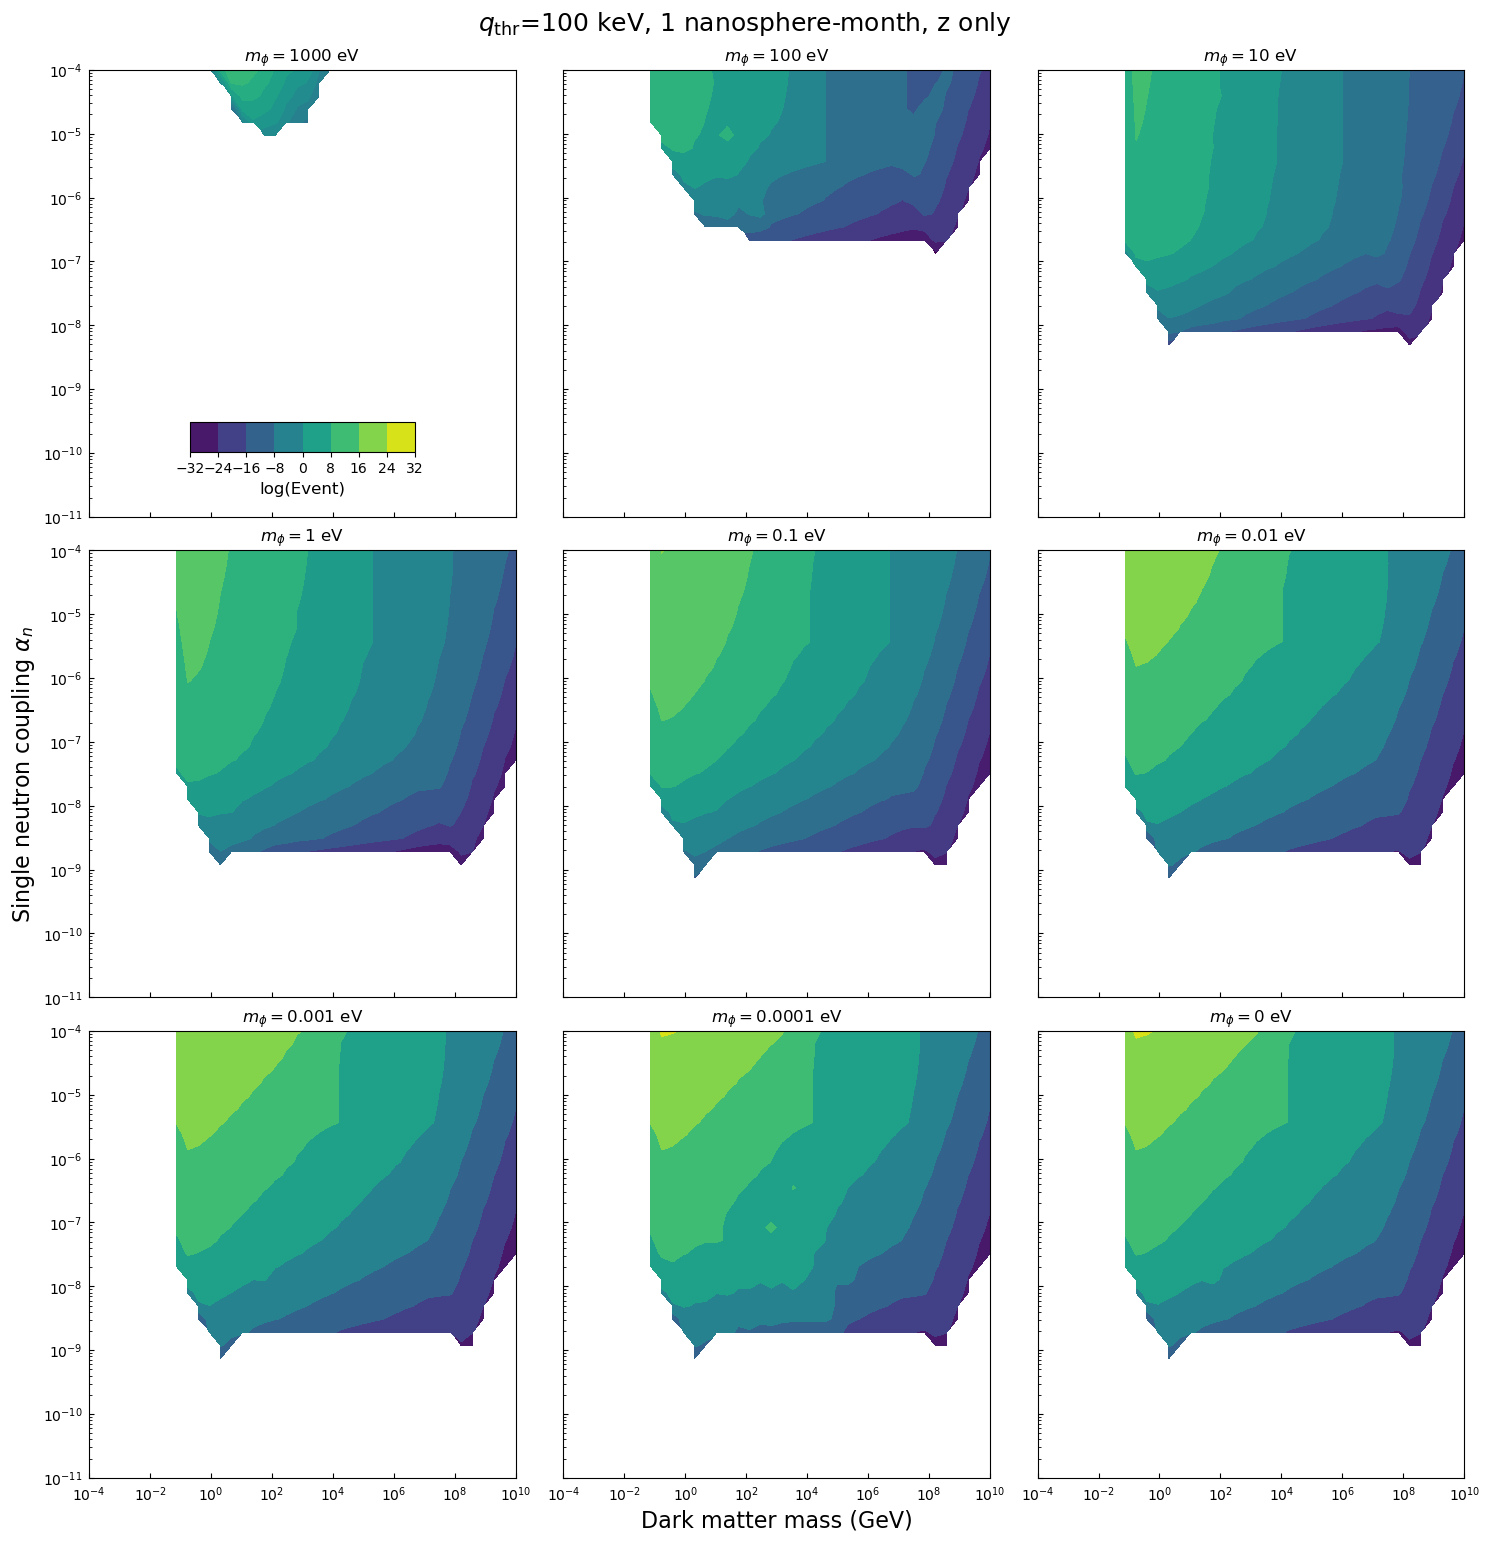

In [30]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_100kev.T),     vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_100kev.T),     vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_100kev.T),      vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_100kev.T),    vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_100kev.T),   vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_100kev.T),  vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_100kev.T), vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_100kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_100kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()

fig.suptitle(r'$q_{\mathrm{thr}}$=100 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

In [31]:
mx_gev_interp, alpha_lim = [], []
for events in [events_0_100kev, events_0_01_100kev,
               events_0_1_100kev, events_1_100kev, events_10_100kev, events_100_100kev, events_1000_100kev]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    alpha_lim.append(lim[1])

/tmp/ipykernel_8781/4076309670.py:15: RuntimeWarning: divide by zero encountered in log10
  events_log = np.log10(events_mx)


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

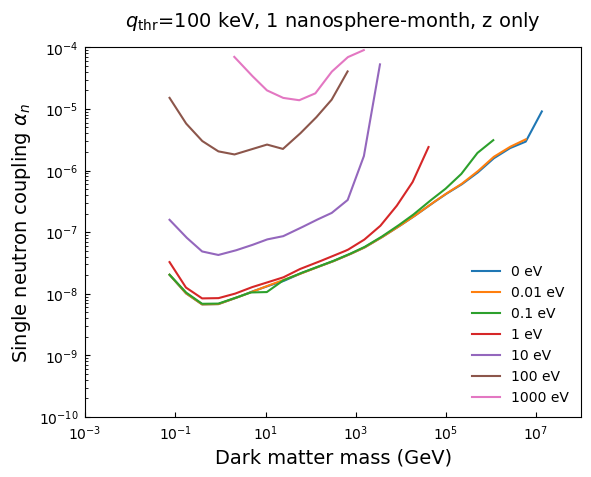

In [32]:
fig, ax = plt.subplots()

mass_plotted = [0, 0.01, 0.1, 1, 10, 100, 1000]
for i, lim in enumerate(alpha_lim):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_ylim(1e-10, 1e-4)
ax.set_xlim(1e-3, 1e8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=100 keV, 1 nanosphere-month, z only', fontsize=14, pad=15)
ax.legend(loc='lower right', frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)v
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

### 500 keV threshold, 1 sphere-month

In [33]:
q_thr = 500e3 / 1e9  # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

events_0_500kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0, q_thr, exposure)
events_0_0001_500kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_500kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_500kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_500kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_500kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1, q_thr, exposure)
events_10_500kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10, q_thr, exposure)
events_100_500kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100, q_thr, exposure)
events_1000_500kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_8781/370089711.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_500kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/370089711.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_500kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/370089711.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_500kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/370089711.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_500kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/370089711.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_500kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_8781/370089711.py:9: RuntimeWarning: divide by zero encountered 

Text(0.5, 1.0, '$m_\\phi =$0 eV')

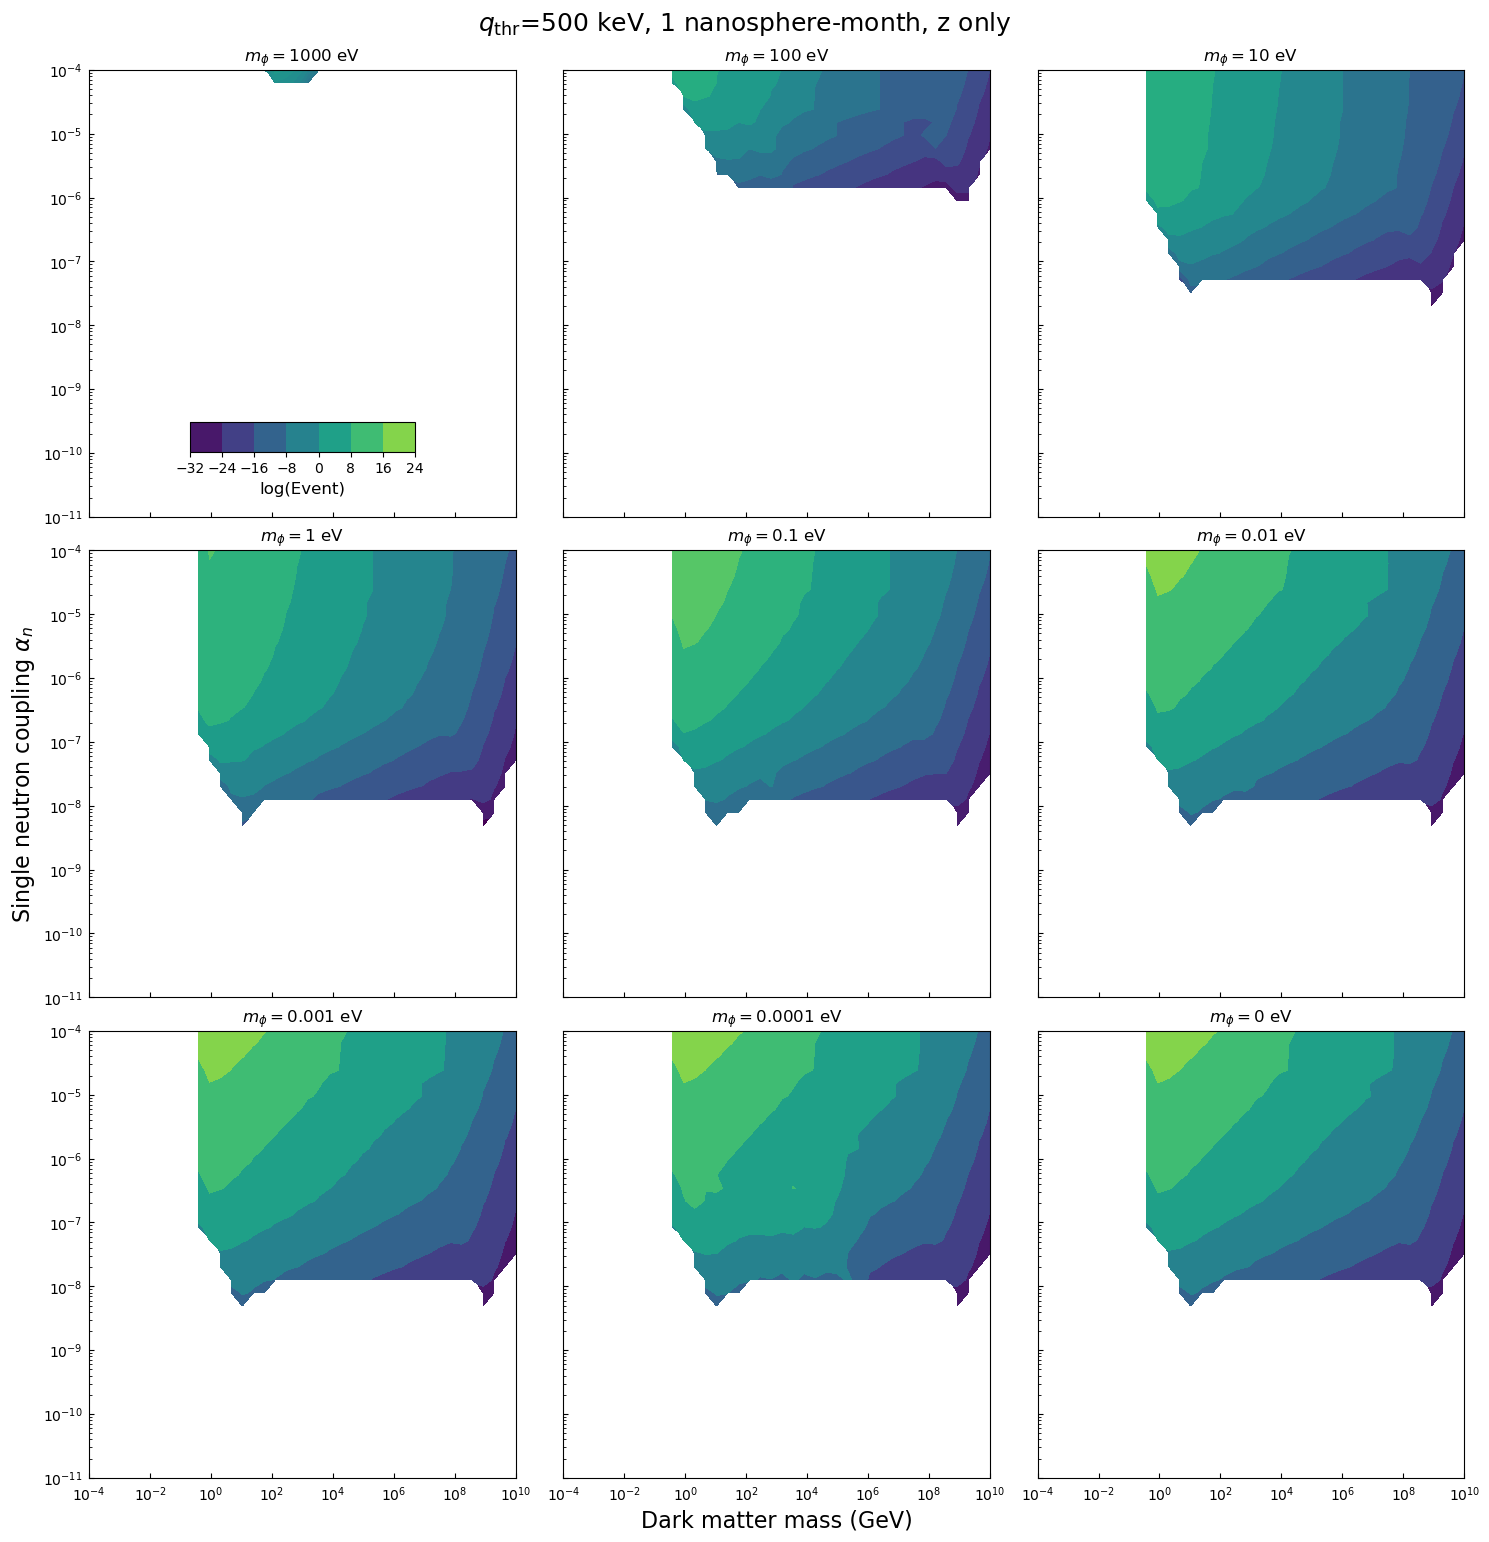

In [34]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_500kev.T),     vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_500kev.T),     vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_500kev.T),      vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_500kev.T),    vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_500kev.T),   vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_500kev.T),  vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_500kev.T), vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_500kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_500kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()

fig.suptitle(r'$q_{\mathrm{thr}}$=500 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

Basically we're not constraining 1000 eV mediator at this point. The sensitivity to 100 eV B-L vector mediator would be similar to $(g-2)_e$ constraints in the best case scenario.

In [35]:
mx_gev_interp, alpha_lim = [], []
for events in [events_0_500kev, events_0_01_500kev,
               events_0_1_500kev, events_1_500kev, events_10_500kev, events_100_500kev]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    alpha_lim.append(lim[1])

/tmp/ipykernel_8781/4076309670.py:15: RuntimeWarning: divide by zero encountered in log10
  events_log = np.log10(events_mx)


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

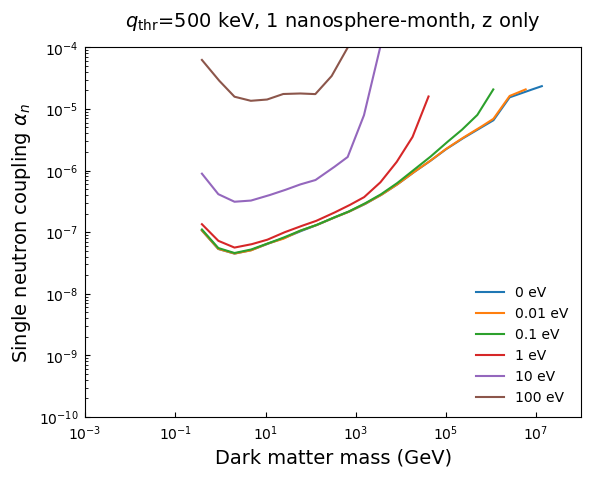

In [36]:
fig, ax = plt.subplots()

mass_plotted = [0, 0.01, 0.1, 1, 10, 100]
for i, lim in enumerate(alpha_lim):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_ylim(1e-10, 1e-4)
ax.set_xlim(1e-3, 1e8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=500 keV, 1 nanosphere-month, z only', fontsize=14, pad=15)
ax.legend(loc='lower right', frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)